# Setup

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.linalg import toeplitz, cholesky
import matplotlib.pyplot as plt
from run_simulations import GenerateDGP
from run_models import CausalInferenceModels

import random
import doubleml as dml
# Main imports
from sklearn.base import clone
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Generate simulated data

- Chernozhukov

In [3]:
n_values = 50
T = 10
alpha=0.5
num_instruments = n_values * (T - 2)
print(f"num_instruments: {num_instruments}")

num_instruments: 400


In [199]:
# Simulation settings
n_values = 15
T = 10
alpha=0.5
num_instruments = n_values * (T - 2)
#num_instruments = int((n_values*T) * 0.5)

generate_dgp = GenerateDGP(n=n_values, T=T, alpha=alpha)

df = generate_dgp.generate_data_chernozhukov(num_instruments=num_instruments)

models = CausalInferenceModels(df=df, y_column='Y', d_columns='D', unit_column='Individual', time_column='Time', desired_alpha=alpha, n=n_values)

#DML setup
dml_data = models.prepare_dml_data()

Num instruments: 120


- Post-selection Chernozhukov example

In [16]:
from utils.import_configs import import_hyperparameters

In [17]:
# Simulation settings
n_values = 50
T = 10
alpha=1
#num_controls = n_values * (T - 2)
num_controls = int((n_values*T) * 0.5)
print(f"num_controls: {num_controls}")
num_instruments = 10

generate_dgp = GenerateDGP(n=n_values, T=T, alpha=alpha)

df = generate_dgp.generate_post_selection_regularization_dgp(n=n_values, px=num_controls, pz=num_instruments)

x_columns = [column for column in df.columns if column.split("_")[0] == "x"]

models = CausalInferenceModels(
    df=df, y_column='y', d_columns='d', x_columns=x_columns, unit_column='unit', time_column='t', 
    desired_alpha=alpha, n=n_values, hp_params=import_hyperparameters())

#DML setup
dml_data = models.prepare_dml_data()

num_controls: 250


In [5]:
pooled_ols_results = models.pooled_2sls()
pooled_ols_results


x_cols is present


{'Coefficient': 1.4606,
 'Bias': 0.4606,
 'Standard Error': 0.0285,
 't-Statistic': 51.327270692044166,
 'p-Value': 0.0,
 '95% CI Lower': 1.4049,
 '95% CI Upper': 1.5164,
 'model_name': 'Pooled 2SLS',
 'size_panel': 100}

In [6]:
fe_2sls_results = models.first_difference_2sls()
fe_2sls_results

x_cols is present


{'Coefficient': 1.4089,
 'Bias': 0.4089,
 'Standard Error': 0.0233,
 't-Statistic': 60.547899428667854,
 'p-Value': 0.0,
 '95% CI Lower': 1.3633,
 '95% CI Upper': 1.4545,
 'model_name': 'First Differences',
 'size_panel': 100}

In [11]:
models.dml_lasso(dml_data)

{'Coefficient': 0.8637,
 'Bias': -0.1363,
 'Standard Error': 0.0847,
 't-Statistic': 10.193078734353033,
 'p-Value': 2.1291257436335493e-24,
 '95% CI Lower': 0.6977,
 '95% CI Upper': 1.0298,
 'model_name': 'DML: LASSO',
 'size_panel': 100}

In [12]:
models.dml_random_forest(dml_data)

{'Coefficient': 1.164,
 'Bias': 0.164,
 'Standard Error': 0.0462,
 't-Statistic': 25.21138371329434,
 'p-Value': 3.005141118734552e-140,
 '95% CI Lower': 1.0735,
 '95% CI Upper': 1.2545,
 'model_name': 'DML: Random Forests',
 'size_panel': 100}

In [13]:
models.dml_xgboost(dml_data)

{'Coefficient': 1.0939,
 'Bias': 0.0939,
 'Standard Error': 0.0595,
 't-Statistic': 18.386174786557692,
 'p-Value': 1.6952723440994296e-75,
 '95% CI Lower': 0.9773,
 '95% CI Upper': 1.2106,
 'model_name': 'DML: XGBoost',
 'size_panel': 100}

In [318]:
# Extract hyperparameters for ml_l, ml_m, and ml_r
ml_l_params = rf_hp['ml_l']['d'][0][0]
ml_m_params = rf_hp['ml_m_instrument_1']['d'][0][0]  # Adjust this key based on the desired instrument
ml_r_params = rf_hp['ml_r']['d'][0][0]


# Define a function to create RandomForestRegressor with given parameters
def create_rf_regressor(params):
    return RandomForestRegressor(
        n_estimators=params['n_estimators'],
        max_features=params['max_features'],
        max_depth=params['max_depth'],
        min_samples_leaf=params['min_samples_leaf'],
        random_state=1234,  # Ensure reproducibility
        n_jobs=-1  # Use all available cores
    )

# Create the RandomForestRegressor objects
ml_l = create_rf_regressor(ml_l_params)
ml_m = create_rf_regressor(ml_m_params)
ml_r = create_rf_regressor(ml_r_params)

In [328]:
dml_pliv_obj_rf = dml.DoubleMLPLIV(dml_data, ml_l, ml_m, ml_r)

# Define the parameter grids for hyperparameter tuning
# par_grids_rf = {'ml_l': {'n_estimators': [50, 100, 200],
#                     'max_features': [5, 10, 15, 20],
#                     'max_depth': [10, 15, 20, 25],
#                     'min_samples_leaf': [1, 2, 4]},
#             'ml_m': {'n_estimators': [50, 100, 200],
#                     'max_features': [5, 10, 15, 20],
#                     'max_depth': [10, 15, 20, 25],
#                     'min_samples_leaf': [1, 2, 4]},
#             'ml_r': {'n_estimators': [50, 100, 200],
#                     'max_features': [5, 10, 15, 20],
#                     'max_depth': [10, 15, 20, 25],
#                     'min_samples_leaf': [1, 2, 4]}}

# Perform hyperparameter tuning
#dml_pliv_obj_rf.tune(par_grids_rf, search_mode='grid_search')

dml_pliv_obj_rf.fit()
results_df = models.generate_point_inference(fit_obj=dml_pliv_obj_rf, model_name="DML: Random Forests", framework="doubleml")
results_df


{'Coefficient': 1.0945,
 'Bias': 0.0945,
 'Standard Error': 0.0589,
 't-Statistic': 18.57133603926963,
 'p-Value': 5.482173423110532e-77,
 '95% CI Lower': 0.979,
 '95% CI Upper': 1.21,
 'model_name': 'DML: Random Forests',
 'size_panel': 100}

In [18]:
from xgboost import XGBRegressor

In [19]:
boost = XGBRegressor(n_jobs=-1, objective = "reg:squarederror",
                     eta=0.1, n_estimators=35)

ml_l_boosting = clone(boost)
ml_m_boosting = clone(boost)
ml_r_boosting = clone(boost)

# For boosting
dml_pliv_obj_boosting = dml.DoubleMLPLIV(dml_data, ml_l_boosting, ml_m_boosting, ml_r_boosting)

#dml_pliv_obj_boosting.fit().summary
fit_obj = dml_pliv_obj_boosting.fit()  # Fit and show summary for boosting
results_df = models.generate_point_inference(fit_obj=fit_obj, model_name="DML: XGBoost", framework="doubleml")
results_df

{'Coefficient': 1.0068,
 'Bias': 0.0068,
 'Standard Error': 0.1,
 't-Statistic': 10.063780969110633,
 'p-Value': 7.987063883267385e-24,
 '95% CI Lower': 0.8107,
 '95% CI Upper': 1.2028,
 'model_name': 'DML: XGBoost',
 'size_panel': 50}

In [ ]:
learner_boosting = GradientBoostingRegressor(n_estimators=200, max_depth=20, learning_rate=0.01, random_state = random.seed(1234))

ml_l_boosting = clone(learner_boosting)
ml_m_boosting = clone(learner_boosting)
ml_r_boosting = clone(learner_boosting)

# For boosting
dml_pliv_obj_boosting = dml.DoubleMLPLIV(dml_data, ml_l_boosting, ml_m_boosting, ml_r_boosting)

#dml_pliv_obj_boosting.fit().summary
fit_obj = dml_pliv_obj_boosting.fit()  # Fit and show summary for boosting
results_df = models.generate_point_inference(fit_obj=fit_obj, model_name="DML: GBM", framework="doubleml")

In [ ]:
learner_boosting = GradientBoostingRegressor(n_estimators=200, max_depth=20, learning_rate=0.01, random_state = random.seed(1234))

ml_l_boosting = clone(learner_boosting)
ml_m_boosting = clone(learner_boosting)
ml_r_boosting = clone(learner_boosting)

# For boosting
dml_pliv_obj_boosting = dml.DoubleMLPLIV(dml_data, ml_l_boosting, ml_m_boosting, ml_r_boosting)

#dml_pliv_obj_boosting.fit().summary
fit_obj = dml_pliv_obj_boosting.fit()  # Fit and show summary for boosting
results_df = models.generate_point_inference(fit_obj=fit_obj, model_name="DML: GBM", framework="doubleml")
results_df


In [8]:
models.dml_lasso(dml_data)

{'Coefficient': 1.2207,
 'Bias': 0.2207,
 'Standard Error': 0.0764,
 't-Statistic': 15.980962908693023,
 'p-Value': 1.734458141929247e-57,
 '95% CI Lower': 1.071,
 '95% CI Upper': 1.3704,
 'model_name': 'DML: LASSO',
 'size_panel': 50}

In [160]:
# For Lasso
learner_lasso = make_pipeline(StandardScaler(), Lasso(alpha=0.01, max_iter=1000, random_state = random.seed(1234)))

ml_l_lasso = clone(learner_lasso)
ml_m_lasso = clone(learner_lasso)
ml_r_lasso = clone(learner_lasso)

dml_pliv_obj_lasso = dml.DoubleMLPLIV(dml_data, ml_l_lasso, ml_m_lasso, ml_r_lasso)
#dml_pliv_obj_lasso.fit().summary  # Fit and show summary for Lasso
lasso_fit = dml_pliv_obj_lasso.fit()
lasso_fit.summary


,coef,std err,t,P>|t|,2.5 %,97.5 %
d,0.972461,0.069958,13.900611,6.280261e-44,0.835345,1.109576


In [141]:
learner = RandomForestRegressor(n_estimators=100, max_features=200, max_depth=15, min_samples_leaf=2, random_state = random.seed(1234))
ml_l = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

dml_pliv_obj_rf = dml.DoubleMLPLIV(dml_data, ml_l, ml_m, ml_r)

dml_pliv_obj_rf.fit()
dml_pliv_obj_rf.summary

,coef,std err,t,P>|t|,2.5 %,97.5 %
d,1.040052,0.05925,17.553671,5.575692e-69,0.923924,1.156179


In [16]:
def generate_post_selection_regularization_dgp(n, px=100, pz=10, nSim=1000):
    # Generate matrices and coefficients
    Sx = cholesky(toeplitz(0.5 ** np.arange(px)))
    Se = cholesky(np.array([[1, 0.6], [0.6, 1]]))
    
    alpha = 1
    beta = (1.0 / (np.arange(1, px + 1))) ** 2
    gamma = beta
    delta = (1.0 / (np.arange(1, pz + 1))) ** 2
    
    theta = np.vstack([np.eye(pz), np.zeros((px - pz, pz))])
    
    # Initialize lists to store results
    results = []
    z_list = []
    x_list = []

    # Simulation loop
    for ii in range(nSim):
        if ii % 10 == 0:
            print(f"Simulation {ii + 1}/{nSim}")
        
        # Generate x
        x = np.random.randn(n, px).dot(Sx)
        
        # Generate z
        z = x.dot(theta) + 0.5 * np.random.randn(n, pz)
        
        # Generate errors
        e = np.random.randn(n, 2).dot(Se)
        
        # Generate d
        d = z.dot(delta) + x.dot(gamma) + e[:, 0]
        
        # Generate y
        y = d * alpha + x.dot(beta) + e[:, 1]
        
        # Store data in results list
        results.append(pd.DataFrame({
            'y': y,
            'd': d
        }))
        
        z_list.append(pd.DataFrame(z, columns=[f'z_{j+1}' for j in range(pz)]))
        x_list.append(pd.DataFrame(x, columns=[f'x_{j+1}' for j in range(px)]))

    # Combine all results into a single DataFrame
    df_results = pd.concat(results, ignore_index=True)
    df_z = pd.concat(z_list, ignore_index=True)
    df_x = pd.concat(x_list, ignore_index=True)

    # Concatenate all DataFrames
    df = pd.concat([df_results, df_z, df_x], axis=1)
    
    return df


In [102]:
def different_specification(n=200, T=10, px=50, pz=5, rho_e=0.5, rho_u=0.5, rho_z=0.5, nSim=1):
    # Initialize lists to store results
    results = []

    # Generate individual heterogeneity
    cov_matrix = np.fromfunction(lambda i, j: 0.5 ** np.abs(i - j), (n, n))
    e = np.random.multivariate_normal(mean=np.zeros(n), cov=cov_matrix * (4 / T))
    
    for sim in range(nSim):
        if sim % 10 == 0:
            print(f"Simulation {sim + 1}/{nSim}")
        
        # Initial disturbances
        epsilon = np.zeros((n, T))
        u = np.zeros((n, T))
        nu = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], size=(n, T))
        
        for t in range(T):
            if t == 0:
                epsilon[:, t] = nu[:, t, 0]
                u[:, t] = nu[:, t, 1]
            else:
                epsilon[:, t] = rho_e * epsilon[:, t-1] + nu[:, t, 0]
                u[:, t] = rho_u * u[:, t-1] + nu[:, t, 1]
        
        # Generate x
        x = np.zeros((n, T, px))
        for j in range(px):
            for t in range(T):
                if t == 0:
                    x[:, t, j] = e / (1 - rho_z) + np.sqrt(1 / (1 - rho_z ** 2)) * np.random.randn(n)
                else:
                    x[:, t, j] = e + rho_z * x[:, t-1, j] + np.random.randn(n)
        
        # Generate z variables as z_{it} = Π x_{it} + ζ_{it}
        Pi = np.hstack([np.eye(pz), np.zeros((pz, px - pz))])
        zeta = np.random.multivariate_normal(mean=np.zeros(pz), cov=0.25 * np.eye(pz), size=(n, T))
        z = np.zeros((n, T, pz))
        for t in range(T):
            z[:, t, :] = np.dot(x[:, t, :], Pi.T) + zeta[:, t, :]
        
        # Generate d and y
        gamma = (1.0 / (np.arange(1, px + 1))) ** 2
        delta = (1.0 / (np.arange(1, pz + 1))) ** 2
        alpha = 1
        beta = gamma
        
        d = np.zeros((n, T))
        y = np.zeros((n, T))
        
        for t in range(T):
            d[:, t] = z[:, t, :].dot(delta) + x[:, t, :].dot(gamma) + u[:, t]
            y[:, t] = alpha * d[:, t] + x[:, t, :].dot(beta) + epsilon[:, t]
        
        # Store data in results list
        for t in range(T):
            df_t = pd.DataFrame({
                'y': y[:, t],
                'd': d[:, t],
                't': t + 1,
                'unit': np.arange(1, n + 1)
            })
            df_t = pd.concat([df_t, pd.DataFrame(z[:, t, :], columns=[f'instrument_{j+1}' for j in range(pz)])], axis=1)
            df_t = pd.concat([df_t, pd.DataFrame(x[:, t, :], columns=[f'x_{j+1}' for j in range(px)])], axis=1)
            results.append(df_t)
    
    # Combine all results into a single DataFrame
    df = pd.concat(results, ignore_index=True)
    
    return df


In [103]:
#df_tst = generate_post_selection_regularization_dgp(n=2000, px=50, pz=10, nSim=1)
df_tst = different_specification()

Simulation 1/1


In [128]:
x_columns = [column for column in df_tst.columns if column.split("_")[0] == "x"]
#instrument_columns = [column for column in df_tst.columns if column.split("_")[0] == "z"]

models = CausalInferenceModels(
    df=df_tst, y_column='y', d_columns='d', x_columns=x_columns, unit_column='unit', time_column='t', 
    desired_alpha=1, n=n_values)

#DML setup
dml_data = models.prepare_dml_data()

x_cols is present


In [ ]:
# Simulation settings
n_values = 100
T = 10
alpha=0.5
num_controls = 100 #n_values * (T - 2)
num_instruments = 10
#num_instruments = int((n_values*T) * 0.5)

generate_dgp = GenerateDGP(n=n_values, T=T, alpha=alpha)

df = generate_dgp.generate_post_selection_regularization_dgp(n=n_values, px=num_controls, pz=num_instruments)

x_columns = [column for column in df.columns if column.split("_")[0] == "x"]

models = CausalInferenceModels(
    df=df, y_column='y', d_columns='d', x_columns=x_columns, unit_column='unit', time_column='t', 
    desired_alpha=1, n=n_values)

#DML setup
dml_data = models.prepare_dml_data()

In [ ]:
learner_boosting = GradientBoostingRegressor(n_estimators=200, max_depth=20, learning_rate=0.01, random_state = random.seed(1234))

ml_l_boosting = clone(learner_boosting)
ml_m_boosting = clone(learner_boosting)
ml_r_boosting = clone(learner_boosting)

# For boosting
dml_pliv_obj_boosting = dml.DoubleMLPLIV(obj_dml_data, ml_l_boosting, ml_m_boosting, ml_r_boosting)

#dml_pliv_obj_boosting.fit().summary
fit_obj = dml_pliv_obj_boosting.fit()  # Fit and show summary for boosting
fit_obj.summary


In [11]:
# Simulation settings
n_values = 100
T = 10
alpha=0.5
#num_instruments = n_values * (T - 2)
num_instruments = int((n_values*T) * 0.5)

generate_dgp = GenerateDGP(n=n_values, T=T, alpha=alpha)

df = generate_dgp.generate_panel_data_controls(num_instruments=num_instruments)

Num instruments: 500


In [14]:
models = CausalInferenceModels(df=df, y_column='Y', d_columns='D', unit_column='Individual', time_column='Time', desired_alpha=alpha, n=n_values)

#DML setup
dml_data = models.prepare_dml_data()

In [12]:
df

,Individual,Time,Y,D,instrument_1,instrument_2,instrument_3,instrument_4,instrument_5,instrument_6,...,instrument_491,instrument_492,instrument_493,instrument_494,instrument_495,instrument_496,instrument_497,instrument_498,instrument_499,instrument_500
0,0,0,-1.674060,-1.982272,-2.461500,-1.971406,-2.041373,-5.823128,-6.145709,-5.100550,...,-1.471868,-4.983973,-2.472912,-3.337018,-3.898268,-1.013344,-1.468571,-1.759895,-2.207342,0.216479
1,0,1,-2.786753,-3.090438,-2.508182,-1.079680,-1.292461,-4.265557,-5.193635,-5.356772,...,-3.252234,-5.614336,-3.178290,-2.867546,-4.311660,-3.086101,-2.335131,-1.999019,-3.560210,-0.614015
2,0,2,-3.477265,-4.218410,-2.957075,-1.524600,-1.866326,-4.865895,-5.265840,-5.888332,...,-3.469498,-4.777109,-3.257247,-2.686026,-4.169475,-2.283974,-3.923927,-0.836898,-3.521573,-2.238576
3,0,3,-3.571020,-3.857510,-3.037427,-2.274362,-3.613443,-4.578301,-5.514706,-5.949623,...,-4.399146,-4.379106,-3.484673,-1.520972,-3.279942,-1.768770,-3.115152,-0.984331,-3.730334,-3.208832
4,0,4,-2.502205,-3.928690,-3.709690,-3.141332,-5.416561,-5.922721,-4.791712,-6.076804,...,-5.949546,-5.594860,-4.061808,-2.359166,-3.979797,-1.116261,-3.642073,-2.049981,-3.977543,-2.200056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,99,5,-3.037310,-1.297596,-2.518163,-2.105176,-3.010691,-3.856899,-3.367223,-3.702406,...,2.406916,0.467824,2.040422,-0.970040,-3.699706,-0.361884,1.299741,-3.845200,-3.791485,-2.330486
996,99,6,-1.320119,0.051374,-1.688447,-2.879906,-1.587688,-2.886131,-2.613670,-3.647331,...,2.594895,0.798193,2.378988,-0.086541,-2.558119,0.453022,1.542643,-2.322761,-2.252259,-1.286103
997,99,7,-1.815813,-1.089741,-2.352763,-3.215657,-2.171880,-4.533924,-3.896783,-4.721973,...,2.503681,0.669955,1.663038,0.782193,-0.552618,-0.151466,0.442441,-3.104201,-2.715501,-1.250742
998,99,8,-1.745511,-0.075177,-2.780074,-3.004792,-1.234465,-2.918915,-1.641018,-2.694701,...,1.488067,0.842930,1.632105,0.373389,-0.347593,-0.970987,-0.513797,-3.008089,-3.147177,-1.502950


In [ ]:


models = CausalInferenceModels(df=df, y_column='Y', d_columns='D', unit_column='Individual', time_column='Time', desired_alpha=alpha, n=n_values)

#DML setup
dml_data = models.prepare_dml_data()

# Running hyperparameter tuning for simulation

- Random Forests

In [316]:
json_path = "/Users/gabrieldiasmp/Documents/pasta_gabriel/codigo/master_thesis/code/hyperparameters/random_forest.json"

# Open the JSON file
with open(json_path, 'r') as file:
    # Load the JSON data
    rf_hp = json.load(file)

In [292]:
rf_ml_l_params = rf_hp['ml_l']['d'][0][0]
rf_ml_l_params["n_jobs"] = -1

rf_ml_r_params = rf_hp['ml_r']['d'][0][0]
rf_ml_r_params["n_jobs"] = -1

rf_ml_m_params = rf_hp['ml_m_instrument_1']['d'][0][0]
rf_ml_m_params["n_jobs"] = -1


dml_pliv_obj_rf = dml_pliv_obj_rf.set_ml_nuisance_params('ml_l', 'd', rf_hp['ml_l']['d'])
dml_pliv_obj_rf = dml_pliv_obj_rf.set_ml_nuisance_params('ml_r', 'd', rf_hp['ml_r']['d'])
dml_pliv_obj_rf = dml_pliv_obj_rf.set_ml_nuisance_params('ml_l', 'd', rf_hp['ml_l']['d'])

In [ ]:
learner = RandomForestRegressor(n_jobs=-1)

ml_l = RandomForestRegressor.set_params(rf_ml_l_params)
ml_r = RandomForestRegressor.set_params(rf_ml_r_params)
ml_m = RandomForestRegressor.set_params(rf_ml_m_params) #### instruments

dml_pliv_obj_rf = dml.DoubleMLPLIV(dml_data, ml_l, ml_m, ml_r)

# # Define the parameter grids for hyperparameter tuning
# par_grids_rf = {'ml_l': {'n_estimators': [50, 100, 200],
#                     'max_features': [20, 50, 100, 200],
#                     'max_depth': [10, 15, 20],
#                     'min_samples_leaf': [1, 2, 4]},
#             'ml_m': {'n_estimators': [50, 100, 200],
#                     'max_features': [20, 50, 100, 200],
#                     'max_depth': [10, 15, 20],
#                     'min_samples_leaf': [1, 2, 4]},
#             'ml_r': {'n_estimators': [50, 100, 200],
#                     'max_features': [20, 50, 100, 200],
#                     'max_depth': [10, 15, 20],
#                     'min_samples_leaf': [1, 2, 4]}}

# # Perform hyperparameter tuning
# dml_pliv_obj_rf.tune(par_grids_rf, search_mode='grid_search')

# print(dml_pliv_obj_rf.params)


In [296]:
dml_pliv_obj_rf = dml_pliv_obj_rf.set_ml_nuisance_params('ml_l', 'd', rf_hp['ml_l']['d'])
dml_pliv_obj_rf = dml_pliv_obj_rf.set_ml_nuisance_params('ml_r', 'd', rf_hp['ml_r']['d'])
dml_pliv_obj_rf = dml_pliv_obj_rf.set_ml_nuisance_params('ml_l', 'd', rf_hp['ml_l']['d'])

In [297]:
dml_pliv_obj_rf.params 

{'ml_l': {'d': [[{'max_depth': 15,
     'max_features': 200,
     'min_samples_leaf': 1,
     'n_estimators': 100,
     'n_jobs': -1},
    {'max_depth': 15,
     'max_features': 200,
     'min_samples_leaf': 1,
     'n_estimators': 100},
    {'max_depth': 15,
     'max_features': 200,
     'min_samples_leaf': 1,
     'n_estimators': 100},
    {'max_depth': 15,
     'max_features': 200,
     'min_samples_leaf': 1,
     'n_estimators': 100},
    {'max_depth': 15,
     'max_features': 200,
     'min_samples_leaf': 1,
     'n_estimators': 100}]]},
 'ml_r': {'d': [[{'max_depth': 20,
     'max_features': 200,
     'min_samples_leaf': 4,
     'n_estimators': 200,
     'n_jobs': -1},
    {'max_depth': 20,
     'max_features': 200,
     'min_samples_leaf': 4,
     'n_estimators': 200},
    {'max_depth': 20,
     'max_features': 200,
     'min_samples_leaf': 4,
     'n_estimators': 200},
    {'max_depth': 20,
     'max_features': 200,
     'min_samples_leaf': 4,
     'n_estimators': 200},
    {'

In [255]:
dml_pliv_obj_rf.fit()
results_df = models.generate_point_inference(fit_obj=dml_pliv_obj_rf, model_name="DML: Random Forests", framework="doubleml")
results_df

KeyboardInterrupt: 

In [249]:
import json

In [251]:
with open("/Users/gabrieldiasmp/Documents/pasta_gabriel/codigo/master_thesis/code/hyperparameters/" + "random_forest.json", 'w') as json_file:
    json.dump(dml_pliv_obj_rf.params, json_file, indent=4)

In [248]:
dml_pliv_obj_rf.params

{'ml_l': {'d': [[{'max_depth': 15,
     'max_features': 200,
     'min_samples_leaf': 1,
     'n_estimators': 100},
    {'max_depth': 15,
     'max_features': 200,
     'min_samples_leaf': 1,
     'n_estimators': 100},
    {'max_depth': 15,
     'max_features': 200,
     'min_samples_leaf': 1,
     'n_estimators': 100},
    {'max_depth': 15,
     'max_features': 200,
     'min_samples_leaf': 1,
     'n_estimators': 100},
    {'max_depth': 15,
     'max_features': 200,
     'min_samples_leaf': 1,
     'n_estimators': 100}]]},
 'ml_r': {'d': [[{'max_depth': 20,
     'max_features': 200,
     'min_samples_leaf': 4,
     'n_estimators': 200},
    {'max_depth': 20,
     'max_features': 200,
     'min_samples_leaf': 4,
     'n_estimators': 200},
    {'max_depth': 20,
     'max_features': 200,
     'min_samples_leaf': 4,
     'n_estimators': 200},
    {'max_depth': 20,
     'max_features': 200,
     'min_samples_leaf': 4,
     'n_estimators': 200},
    {'max_depth': 20,
     'max_features': 2

- XGBoost

In [ ]:
# Define the parameter grids for hyperparameter tuning for XGBoost
par_grids_xgb = {
    'ml_l': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 15, 20, 25],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'min_child_weight': [1, 5, 10],
        'reg_alpha': [0, 0.01, 0.1, 1],
        'reg_lambda': [1, 1.5, 2]
    },
    'ml_m': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 15, 20, 25],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'min_child_weight': [1, 5, 10],
        'reg_alpha': [0, 0.01, 0.1, 1],
        'reg_lambda': [1, 1.5, 2]
    },
    'ml_r': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 15, 20, 25],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'min_child_weight': [1, 5, 10],
        'reg_alpha': [0, 0.01, 0.1, 1],
        'reg_lambda': [1, 1.5, 2]
    }
}


boost = XGBRegressor(n_jobs=-1, objective = "reg:squarederror",
                     eta=0.1, n_estimators=35)

ml_l_boosting = clone(boost)
ml_m_boosting = clone(boost)
ml_r_boosting = clone(boost)

# For boosting
dml_pliv_obj_boosting = dml.DoubleMLPLIV(dml_data, ml_l_boosting, ml_m_boosting, ml_r_boosting)

# Perform hyperparameter tuning
dml_pliv_obj_boosting.tune(par_grids_xgb, search_mode='grid_search')

print(dml_pliv_obj_boosting.params)


# Run traditional Econometrics

- Pooled 2SLS

In [157]:
models.pooled_2sls()

{'Coefficient': [0.7724717411475097],
 'Bias': [0.2725],
 'Standard Error': [0.0407],
 't-Statistic': [18.971954599166533],
 'p-Value': [0.0],
 '95% CI Lower': [0.6926688518979972],
 '95% CI Upper': [0.8522746303970222],
 'model_name': 'Pooled 2SLS'}

- FD 2SLS

In [158]:
models.first_difference_2sls()

{'Coefficient': [0.7084966710677669],
 'Bias': [0.2085],
 'Standard Error': [0.0322],
 't-Statistic': [22.008836982744334],
 'p-Value': [0.0],
 '95% CI Lower': [0.645402562117436],
 '95% CI Upper': [0.7715907800180979],
 'model_name': 'First Differences'}

# Run DML

- LASSO

In [15]:
models.dml_lasso(dml_data)

{'Coefficient': 1.0326,
 'Bias': 0.5326,
 'Standard Error': 0.0359,
 't-Statistic': 28.79163665724218,
 'p-Value': 2.729824177338479e-182,
 '95% CI Lower': 0.9623,
 '95% CI Upper': 1.1029,
 'model_name': 'DML: LASSO',
 'size_panel': 100}

- Gradient Boosting

In [4]:
import doubleml as dml
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import clone


In [15]:
learner_boosting = GradientBoostingRegressor(n_estimators=200, max_depth=50, learning_rate=0.01)

ml_l_boosting = clone(learner_boosting)
ml_m_boosting = clone(learner_boosting)
ml_r_boosting = clone(learner_boosting)

# For boosting
dml_pliv_obj_boosting = dml.DoubleMLPLIV(dml_data, ml_l_boosting, ml_m_boosting, ml_r_boosting)


In [17]:
# fit_obj = dml_pliv_obj_boosting._partialXZ(dml_data, ml_l_boosting, ml_m_boosting, ml_r_boosting).fit()

fit_obj = dml_pliv_obj_boosting._partialXZ(dml_data, ml_l_boosting, ml_m_boosting,ml_r_boosting).fit() #ml_l_boosting, ml_m_boosting,
results_df = models.generate_point_inference(fit_obj=fit_obj, model_name="DML: Gradient Boosting", framework="doubleml")
results_df


{'Coefficient': 0.4272,
 'Bias': -0.0728,
 'Standard Error': 0.0572,
 't-Statistic': 7.475335716458476,
 'p-Value': 7.700700657336041e-14,
 '95% CI Lower': 0.3152,
 '95% CI Upper': 0.5392,
 'model_name': 'DML: Gradient Boosting',
 'size_panel': 50}

In [29]:
print(fit_obj)

================== DoubleMLPLIV Object ==================

------------------ Data summary      ------------------
Outcome variable: Y
Treatment variable(s): ['D']
Cluster variable(s): ['Individual']
Covariates: ['individual_0', 'individual_1', 'individual_2', 'individual_3', 'individual_4', 'individual_5', 'individual_6', 'individual_7', 'individual_8', 'individual_9', 'individual_10', 'individual_11', 'individual_12', 'individual_13', 'individual_14', 'individual_15', 'individual_16', 'individual_17', 'individual_18', 'individual_19', 'individual_20', 'individual_21', 'individual_22', 'individual_23', 'individual_24', 'individual_25', 'individual_26', 'individual_27', 'individual_28', 'individual_29', 'individual_30', 'individual_31', 'individual_32', 'individual_33', 'individual_34', 'individual_35', 'individual_36', 'individual_37', 'individual_38', 'individual_39', 'individual_40', 'individual_41', 'individual_42', 'individual_43', 'individual_44', 'individual_45', 'individual_46'

- Random Forests

In [346]:
models.dml_random_forest(dml_data)

{'Coefficient': 1.0625,
 'Bias': 0.0625,
 'Standard Error': 0.0821,
 't-Statistic': 12.93630190711105,
 'p-Value': 2.8082524144238326e-38,
 '95% CI Lower': 0.9015,
 '95% CI Upper': 1.2235,
 'model_name': 'DML: Random Forests',
 'size_panel': 50}

## Run all simulations

In [3]:
# Simulation settings
n_values = [50, 100, 150, 200]
T = 10
alpha=0.5

list_of_results = []
for n in n_values:
    # Instantiate DGP class
    generate_dgp = GenerateDGP(n=n, T=T, alpha=alpha)

    # Specify instruments
    #num_instruments = n_values * (T - 2)
    num_instruments = int((n*T) * 0.5)
    df = generate_dgp.generate_data_chernozhukov(num_instruments=num_instruments)

    # Instantiate model's class
    models = CausalInferenceModels(
        df=df, y_column='Y', d_columns='D', unit_column='Individual', time_column='Time', 
        desired_alpha=alpha, n=n)

    # DML setup
    dml_data = models.prepare_dml_data()

    # Run models
    pooled_ols_results = models.pooled_2sls()
    fe_2sls_results = models.first_difference_2sls()
    lasso_results = models.dml_lasso(dml_data)
    random_forest_results = models.dml_random_forest(dml_data)
    gbm_results = models.dml_gbm(dml_data)

    list_of_results.append([pooled_ols_results, fe_2sls_results, lasso_results, random_forest_results, gbm_results])
    
    
# Flatten the list of lists
flat_list = [item for sublist in list_of_results for item in sublist]

# Convert the flattened list into a DataFrame
df_results = pd.DataFrame(flat_list)

df_results.to_excel(
    "/Users/gabrieldiasmp/Documents/pasta_gabriel/codigo/master_thesis/data/results_simulation_50_pct_v2.xlsx",
    index=False
)
print("----- success! ----")
    

Num instruments: 250
Num instruments: 500
Num instruments: 750
Num instruments: 1000
----- success! ----


In [176]:
lasso_results

{'Coefficient': [0.7056874864673762],
 'Bias': [0.2057],
 'Standard Error': [0.0264],
 't-Statistic': [26.726668531428064],
 'p-Value': [2.306210930163694e-157],
 '95% CI Lower': [0.6539368518459967],
 '95% CI Upper': [0.7574381210887557],
 'model_name': 'DML: LASSO'}

In [175]:
list_of_results[1][0]

{'Coefficient': [0.7056874864673762],
 'Bias': [0.2057],
 'Standard Error': [0.0264],
 't-Statistic': [26.726668531428064],
 'p-Value': [2.306210930163694e-157],
 '95% CI Lower': [0.6539368518459967],
 '95% CI Upper': [0.7574381210887557],
 'model_name': 'DML: LASSO'}

In [171]:
# Flatten the list of dictionaries
flat_list = [{k: v for d in sublist for k, v in d.items()} for sublist in list_of_results]

# Convert the flattened list into a DataFrame
df = pd.DataFrame(flat_list)

In [179]:
# Flatten the list of lists
flat_list = [item for sublist in list_of_results for item in sublist]

# Convert the flattened list into a DataFrame
df = pd.DataFrame(flat_list)

In [180]:
df

,Coefficient,Bias,Standard Error,t-Statistic,p-Value,95% CI Lower,95% CI Upper,model_name
0,[0.6847384422411675],[0.1847],[0.0345],[19.820863417818444],[1.967047992045941e-87],[0.6170288446655005],[0.7524480398168346],DML: LASSO
1,[0.6986151149702423],[0.1986],[0.0315],[22.208988103816704],[2.81199211563807e-109],[0.6369616772721208],[0.7602685526683638],DML: Random Forests
2,[0.7056874864673762],[0.2057],[0.0264],[26.726668531428064],[2.306210930163694e-157],[0.6539368518459967],[0.7574381210887557],DML: LASSO
3,[0.708202238023101],[0.2082],[0.0264],[26.79785389408469],[3.422793976752989e-158],[0.6564051468910258],[0.7599993291551762],DML: Random Forests


In [173]:
len(list_of_results)

2

In [172]:
df

,Coefficient,Bias,Standard Error,t-Statistic,p-Value,95% CI Lower,95% CI Upper,model_name
0,[0.6986151149702423],[0.1986],[0.0315],[22.208988103816704],[2.81199211563807e-109],[0.6369616772721208],[0.7602685526683638],DML: Random Forests
1,[0.708202238023101],[0.2082],[0.0264],[26.79785389408469],[3.422793976752989e-158],[0.6564051468910258],[0.7599993291551762],DML: Random Forests


In [129]:
tst_list = []

tst_list.append([{'bla': 1}, {"ble": 2}], [{'bla': 3}, {"ble": 4}], [{'bla': 5}, {"ble": 6}])

In [178]:
# Initialize the list of JSON-like dictionaries
tst_list = [
    [{'bla': 1, "ble": 2}, {'bla': 3, "ble": 4}],
    [{'bla': 3123, "ble": 6556}, {'bla': 123312, "ble": 213312}],
    [{'bla': 88, "ble": 88888}, {'bla': 2245345, "ble": 2234234}]
]

# Flatten the list of lists
flat_list = [item for sublist in tst_list for item in sublist]

# Convert the flattened list into a DataFrame
df = pd.DataFrame(flat_list)

print(df)
# Flatten the list of dictionaries
#flat_list = [{k: v for d in sublist for k, v in d.items()} for sublist in tst_list]

# Convert the flattened list into a DataFrame
#df = pd.DataFrame(flat_list)

#print(df)

       bla      ble
0        1        2
1        3        4
2     3123     6556
3   123312   213312
4       88    88888
5  2245345  2234234


In [132]:
import pandas as pd
pd.DataFrame(tst_list)

,0,1
0,{'bla': 1},{'bla': 2}


- EconML

In [48]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso


In [ ]:
estimator = models.econml_doubleml(
    model_y=RandomForestRegressor(), 
    model_t=RandomForestRegressor(),
    model_z=RandomForestRegressor(),
    model_final=LinearRegression(fit_intercept=False)
    )

In [ ]:
estimator.ate_inference()

# Sandbox

- Simulation results

In [22]:
simulation_table = pd.read_excel("/Users/gabrieldiasmp/Documents/pasta_gabriel/codigo/master_thesis/data/results_simulation_controls_and_instruments_MERGE.xlsx")

In [28]:
simulation_table["rmse"] = simulation_table["Bias"]**2

In [29]:
simulation_table

,Coefficient,Bias,Standard Error,t-Statistic,p-Value,95% CI Lower,95% CI Upper,model_name,size_panel,simulation,rmse
0,0.7954,0.2954,0.0632,12.578200,0.000000e+00,0.6715,0.9193,Pooled 2SLS,15,1,0.087261
1,0.9756,0.4756,0.0339,28.747429,0.000000e+00,0.9091,1.0421,Pooled 2SLS,50,1,0.226195
2,0.8716,0.3716,0.0258,33.814775,0.000000e+00,0.8211,0.9221,Pooled 2SLS,100,1,0.138087
3,0.8888,0.3888,0.0190,46.819670,0.000000e+00,0.8516,0.9260,Pooled 2SLS,200,1,0.151165
4,0.6733,0.1733,0.0551,12.210876,0.000000e+00,0.5653,0.7814,First Differences,15,1,0.030033
...,...,...,...,...,...,...,...,...,...,...,...
595,0.5399,0.0399,0.0383,14.099629,3.817729e-45,0.4649,0.6150,DML: Random Forests,200,30,0.001592
596,0.7366,0.2366,0.0784,9.390829,5.952973e-21,0.5829,0.8903,DML: LASSO,15,30,0.055980
597,0.3964,-0.1036,0.0861,4.604780,4.129023e-06,0.2277,0.5651,DML: LASSO,50,30,0.010733
598,0.5897,0.0897,0.0509,11.576771,5.404342e-31,0.4899,0.6896,DML: LASSO,100,30,0.008046


In [ ]:
# Group by 'model_name' and 'panel_size' and calculate the mean of 'bias' and 'rmse'
result = simulation_table.groupby(['model_name', 'panel_size'])[['Bias', 'rmse', 'Standard Error']].mean().reset_index()


In [36]:
# Group by 'model_name' and 'panel_size'
grouped = simulation_table.groupby(['model_name', 'size_panel'])

# Calculate the mean of 'bias' and standard errors
mean_bias = grouped['Bias'].mean()
mean_std = grouped['Standard Error'].mean()

# Calculate the RMSE
rmse = grouped['Bias'].apply(lambda x: np.sqrt(np.mean(np.square(x))))

# Combine the results into a single DataFrame
result = pd.DataFrame({'bias': np.round(mean_bias, 4), 'rmse': np.round(rmse, 4), "clustered_std": np.round(mean_std, 4)}).reset_index()

print(result)

             model_name  size_panel    bias    rmse  clustered_std
0            DML: LASSO          15  0.1410  0.2243         0.1152
1            DML: LASSO          50  0.0501  0.1228         0.0724
2            DML: LASSO         100  0.0276  0.0678         0.0580
3            DML: LASSO         200  0.0183  0.0517         0.0401
4   DML: Random Forests          15  0.1475  0.1810         0.1091
5   DML: Random Forests          50  0.0656  0.0872         0.0691
6   DML: Random Forests         100  0.0383  0.0692         0.0528
7   DML: Random Forests         200  0.0361  0.0531         0.0376
8          DML: XGBoost          15  0.1242  0.2142         0.1398
9          DML: XGBoost          50  0.0624  0.1026         0.0801
10         DML: XGBoost         100  0.0316  0.0627         0.0580
11         DML: XGBoost         200  0.0293  0.0482         0.0394
12    First Differences          15  0.3012  0.3142         0.0609
13    First Differences          50  0.3341  0.3376         0.

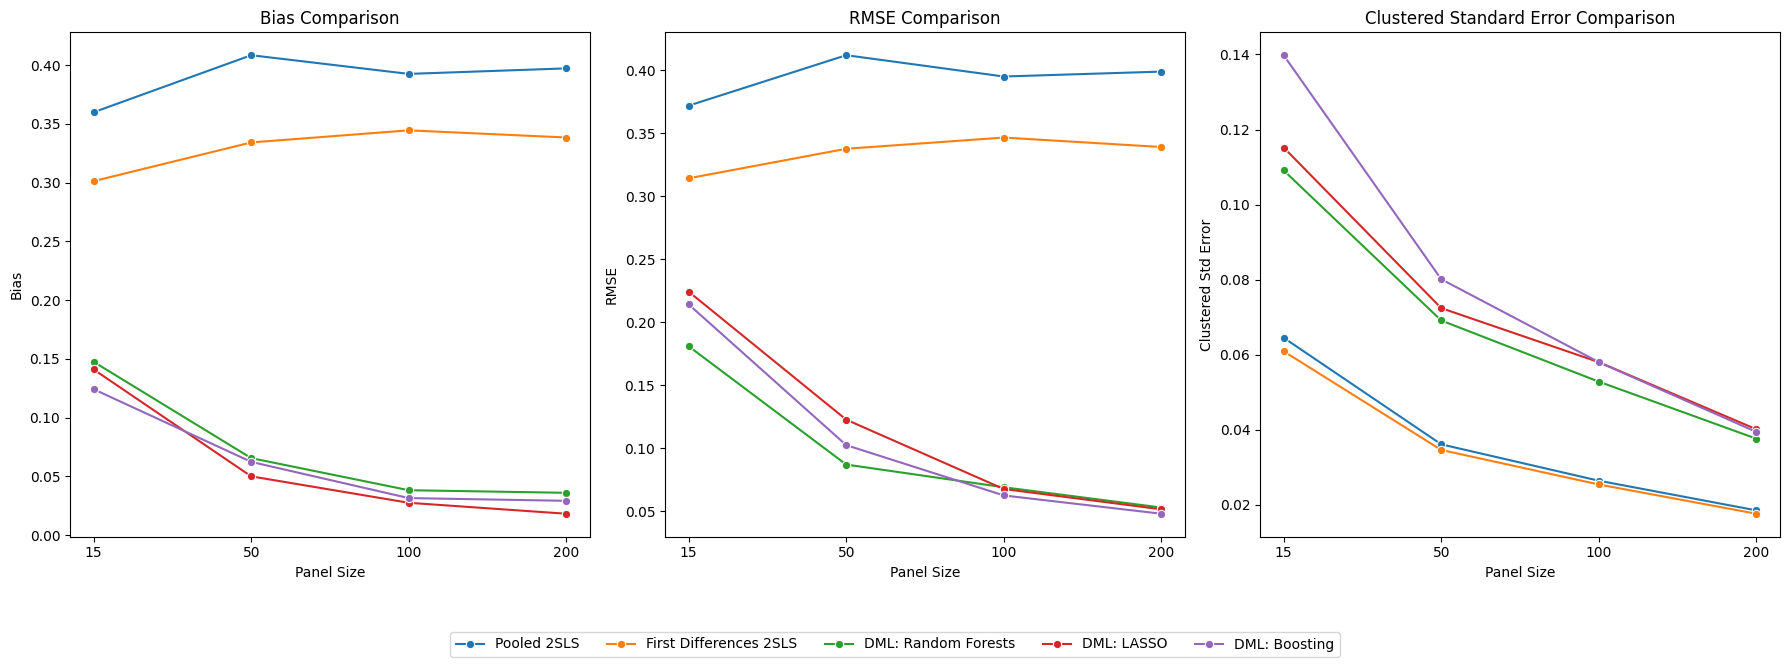

In [47]:
# Define the data
data = {
    'Model': ['Pooled 2SLS'] * 4 + ['First Differences 2SLS'] * 4 + ['DML: Random Forests'] * 4 + ['DML: LASSO'] * 4 + ['DML: Boosting'] * 4,
    'Panel Size': [15, 50, 100, 200] * 5,
    'Bias': [0.3598, 0.4083, 0.3924, 0.3971, 
             0.3012, 0.3341, 0.3444, 0.3383,
             0.1475, 0.0656, 0.0383, 0.0361,
             0.1410, 0.0501, 0.0276, 0.0183,
             0.1242, 0.0624, 0.0316, 0.0293],
    'RMSE': [0.3718, 0.4118, 0.3949, 0.3988,
             0.3142, 0.3376, 0.3465, 0.3390,
             0.1810, 0.0872, 0.0692, 0.0531,
             0.2243, 0.1228, 0.0678, 0.0517,
             0.2142, 0.1026, 0.0627, 0.0482],
    'Clustered Std': [0.0645, 0.0361, 0.0264, 0.0185,
                      0.0609, 0.0346, 0.0254, 0.0176,
                      0.1091, 0.0691, 0.0528, 0.0376,
                      0.1152, 0.0724, 0.0580, 0.0401,
                      0.1398, 0.0801, 0.0580, 0.0394]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create a mapping for even spacing
panel_sizes = [15, 50, 100, 200]
panel_mapping = {size: i for i, size in enumerate(panel_sizes)}

# Apply the mapping to a new column for even spacing
df['Panel Size Mapped'] = df['Panel Size'].map(panel_mapping)

# Plot Bias
sns.lineplot(data=df, x='Panel Size Mapped', y='Bias', hue='Model', marker='o', ax=axes[0])
axes[0].set_title('Bias Comparison')
axes[0].set_xlabel('Panel Size')
axes[0].set_ylabel('Bias')
axes[0].set_xticks(list(panel_mapping.values()))
axes[0].set_xticklabels(panel_sizes)

# Plot RMSE
sns.lineplot(data=df, x='Panel Size Mapped', y='RMSE', hue='Model', marker='o', ax=axes[1])
axes[1].set_title('RMSE Comparison')
axes[1].set_xlabel('Panel Size')
axes[1].set_ylabel('RMSE')
axes[1].set_xticks(list(panel_mapping.values()))
axes[1].set_xticklabels(panel_sizes)

# Plot Clustered Std Error
sns.lineplot(data=df, x='Panel Size Mapped', y='Clustered Std', hue='Model', marker='o', ax=axes[2])
axes[2].set_title('Clustered Standard Error Comparison')
axes[2].set_xlabel('Panel Size')
axes[2].set_ylabel('Clustered Std Error')
axes[2].set_xticks(list(panel_mapping.values()))
axes[2].set_xticklabels(panel_sizes)

# Add a single legend in the middle
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.05))

# Remove individual legends
for ax in axes:
    ax.legend().remove()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

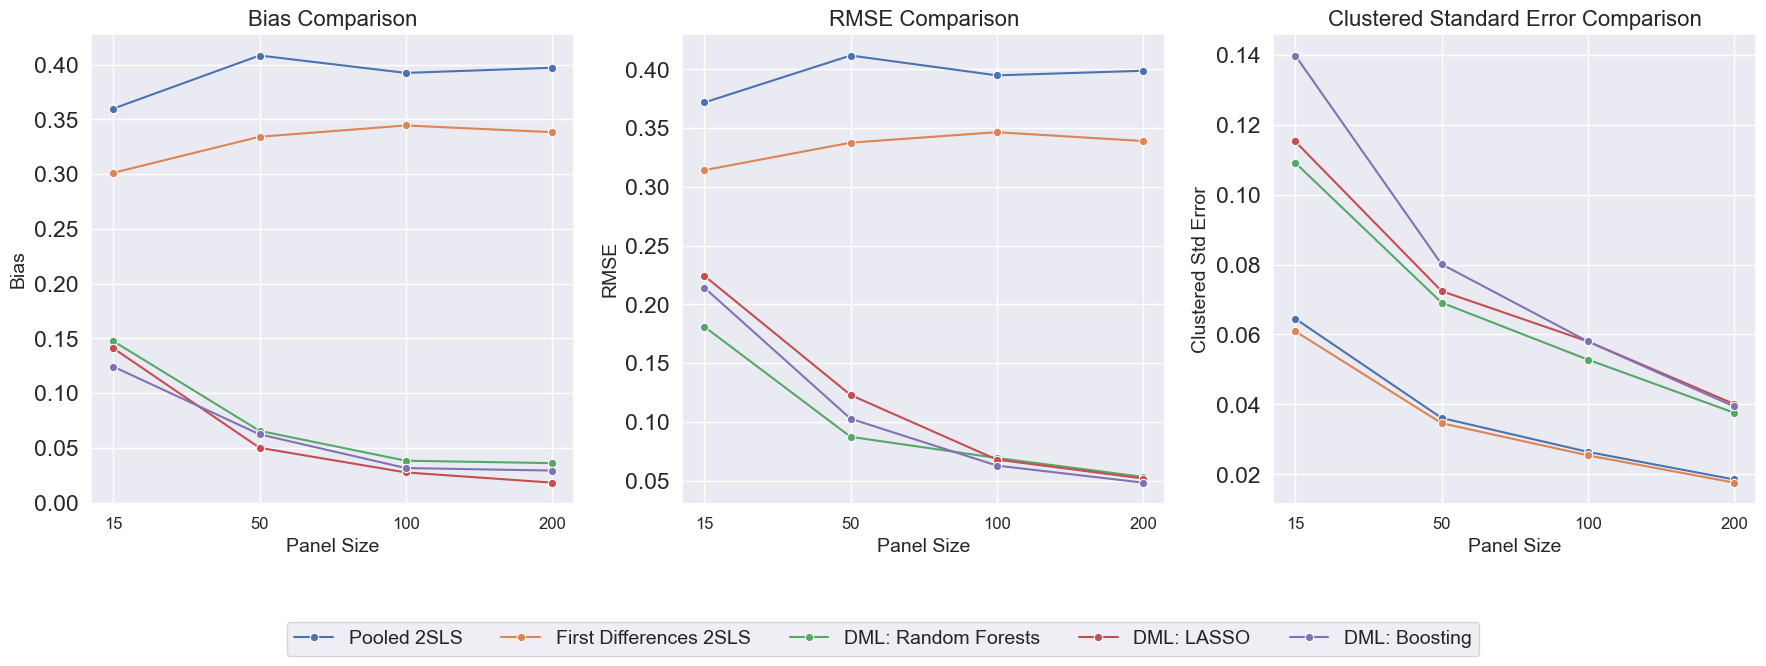

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define the data
data = {
    'Model': ['Pooled 2SLS'] * 4 + ['First Differences 2SLS'] * 4 + ['DML: Random Forests'] * 4 + ['DML: LASSO'] * 4 + ['DML: Boosting'] * 4,
    'Panel Size': [15, 50, 100, 200] * 5,
    'Bias': [0.3598, 0.4083, 0.3924, 0.3971, 
             0.3012, 0.3341, 0.3444, 0.3383,
             0.1475, 0.0656, 0.0383, 0.0361,
             0.1410, 0.0501, 0.0276, 0.0183,
             0.1242, 0.0624, 0.0316, 0.0293],
    'RMSE': [0.3718, 0.4118, 0.3949, 0.3988,
             0.3142, 0.3376, 0.3465, 0.3390,
             0.1810, 0.0872, 0.0692, 0.0531,
             0.2243, 0.1228, 0.0678, 0.0517,
             0.2142, 0.1026, 0.0627, 0.0482],
    'Clustered Std': [0.0645, 0.0361, 0.0264, 0.0185,
                      0.0609, 0.0346, 0.0254, 0.0176,
                      0.1091, 0.0691, 0.0528, 0.0376,
                      0.1152, 0.0724, 0.0580, 0.0401,
                      0.1398, 0.0801, 0.0580, 0.0394]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Set up the font scale for seaborn
sns.set(font_scale=1.5)

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Create a mapping for even spacing
panel_sizes = [15, 50, 100, 200]
panel_mapping = {size: i for i, size in enumerate(panel_sizes)}

# Apply the mapping to a new column for even spacing
df['Panel Size Mapped'] = df['Panel Size'].map(panel_mapping)

# Plot Bias
sns.lineplot(data=df, x='Panel Size Mapped', y='Bias', hue='Model', marker='o', ax=axes[0])
axes[0].set_title('Bias Comparison', fontsize=16)
axes[0].set_xlabel('Panel Size', fontsize=14)
axes[0].set_ylabel('Bias', fontsize=14)
axes[0].set_xticks(list(panel_mapping.values()))
axes[0].set_xticklabels(panel_sizes, fontsize=12)

# Plot RMSE
sns.lineplot(data=df, x='Panel Size Mapped', y='RMSE', hue='Model', marker='o', ax=axes[1])
axes[1].set_title('RMSE Comparison', fontsize=16)
axes[1].set_xlabel('Panel Size', fontsize=14)
axes[1].set_ylabel('RMSE', fontsize=14)
axes[1].set_xticks(list(panel_mapping.values()))
axes[1].set_xticklabels(panel_sizes, fontsize=12)

# Plot Clustered Std Error
sns.lineplot(data=df, x='Panel Size Mapped', y='Clustered Std', hue='Model', marker='o', ax=axes[2])
axes[2].set_title('Clustered Standard Error Comparison', fontsize=16)
axes[2].set_xlabel('Panel Size', fontsize=14)
axes[2].set_ylabel('Clustered Std Error', fontsize=14)
axes[2].set_xticks(list(panel_mapping.values()))
axes[2].set_xticklabels(panel_sizes, fontsize=12)

# Add a single legend in the middle
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, bbox_to_anchor=(0.5, -0.05), fontsize=14)

# Remove individual legends
for ax in axes:
    ax.legend().remove()

# Adjust layout and show plot
plt.tight_layout()
plt.show()


- Evaluating the disturbances

In [19]:
n=100
T=10
px=50
pz=5
rho_e=0.5
rho_u=0.5
rho_z=0.5

In [20]:
# Initial disturbances
epsilon = np.zeros((n, T))
u = np.zeros((n, T))
nu = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1]], size=(n, T))

for t in range(T):
    if t == 0:
        epsilon[:, t] = nu[:, t, 0]
        u[:, t] = nu[:, t, 1]
    else:
        epsilon[:, t] = rho_e * epsilon[:, t-1] + nu[:, t, 0]
        u[:, t] = rho_u * u[:, t-1] + nu[:, t, 1]


In [46]:
nu.shape

(100, 10, 2)

In [50]:
nu[2]

array([[ 0.775116  ,  0.83771514],
       [ 0.12681755,  0.51715359],
       [-0.33480796, -1.94184472],
       [-0.31851406, -1.56227018],
       [-1.69425325, -1.24289633],
       [-0.33268363,  0.05397906],
       [ 0.01110712, -0.18118249],
       [-1.55124595, -0.96381759],
       [ 0.86315375,  0.46874688],
       [-0.89423607, -0.5458834 ]])

In [51]:
nu[2, 0, 0]

0.7751160030777144

In [52]:
rho_e * epsilon[2,0] + nu[2, 1, 0]

0.514375549719144

In [44]:
epsilon.shape

(100, 10)

In [53]:
epsilon[2]

array([ 0.775116  ,  0.51437555, -0.07762019, -0.35732416, -1.87291533,
       -1.2691413 , -0.62346353, -1.86297771, -0.0683351 , -0.92840362])

In [36]:
rho_e * epsilon[0, 0] + nu[0, 0, 0]

0.5934282183847206

- Evaluating the Xs

In [55]:
# Generate individual heterogeneity
cov_matrix = np.fromfunction(lambda i, j: 0.5 ** np.abs(i - j), (n, n))
e = np.random.multivariate_normal(mean=np.zeros(n), cov=cov_matrix * (4 / T))

In [81]:
phi_t = np.random.normal(scale=np.sqrt(1), size=px)

In [ ]:
phi = np.random.normal(size=T)

In [137]:
def generate_controls(n, T, px, rho_x, e, phi):
    x = np.zeros((n, T, px))
    
    for i in range(n):
        for j in range(px):
            for t in range(T):
                if t == 0:
                    x[i, t, j] = e[i] / (1 - rho_x) + np.sqrt(1 / (1 - rho_x**2)) * phi[t]
                else:
                    x[i, t, j] = e[i] + rho_x * x[i, t-1, j] + phi[t]
                    
    return x

# Example usage
rho_x = 0.5
px = 5
x = generate_controls(n, T, px, rho_x, e, phi)

In [138]:
def print_initial_values(epsilon, u, x, n=1, T=5, px=1):
    # print("First few values of epsilon:")
    # for i in range(n):
    #     for t in range(T):
    #         print(f"epsilon[{i},{t}] = {epsilon[i,t]}")
    
    # print("\nFirst few values of u:")
    # for i in range(n):
    #     for t in range(T):
    #         print(f"u[{i},{t}] = {u[i,t]}")
    
    print("\nFirst few values of x:")
    for i in range(n):
        for t in range(T):
            for j in range(px):
                print(f"x[{i},{t},{j}] = {x[i,t,j]}")

# Example usage
print_initial_values(epsilon, u, x)


First few values of x:
x[0,0,0] = -0.5201483122554315
x[0,1,0] = 1.6614195281758282
x[0,2,0] = 1.0198483449817792
x[0,3,0] = 1.1476091995824733
x[0,4,0] = 1.028036629930661


In [139]:
tst = np.zeros((n, T, px))
tst.shape

(100, 10, 5)

In [140]:
# For t = 0
tst[0, 0, 0] = e[0] / (1 - rho_x) + np.sqrt(1 / (1 - rho_x**2)) * phi[0]
print(f"x[0, 0, 0]: {tst[0, 0, 0]}")

# For t = 1
tst[0, 1, 0] = e[0] + rho_x * x[0, 0, 0] + phi[1]
print(f"x[0, 1, 0]: {tst[0, 1, 0]}")

# For t = 2
tst[0, 2, 0] = e[0] + rho_x * x[0, 1, 0] + phi[2]
print(f"x[0, 2, 0]: {tst[0, 2, 0]}")

# For t = 3
tst[0, 3, 0] = e[0] + rho_x * x[0, 2, 0] + phi[3]
print(f"x[0, 3, 0]: {tst[0, 3, 0]}")

# For t = 4
tst[0, 4, 0] = e[0] + rho_x * x[0, 3, 0] + phi[4]
print(f"x[0, 4, 0]: {tst[0, 4, 0]}")


x[0, 0, 0]: -0.5201483122554315
x[0, 1, 0]: 1.6614195281758282
x[0, 2, 0]: 1.0198483449817792
x[0, 3, 0]: 1.1476091995824733
x[0, 4, 0]: 1.028036629930661


In [95]:
e + rho_z * x[:, 0, 0] + phi_t[0]


array([ 0.78102228,  1.18408389,  0.74340835,  0.19640834, -1.13709727,
        0.61537011, -0.93070044, -1.14251863,  0.23145075, -1.60785744,
       -1.4237987 ,  0.13208457,  0.68398082,  0.21970581,  1.11438412,
       -0.41850569, -1.1665953 , -0.12863216, -0.02257906, -0.57757132,
       -0.49193369, -0.50906445,  1.11962876,  0.58368339,  1.60448154,
        1.25174266,  0.43503229, -2.74003547, -2.49506343, -0.48791238,
        0.79829528,  0.31298726,  0.87552982, -0.64768063,  1.32412136,
        1.56556387,  0.59038859,  2.06866193,  0.36877927,  0.41988746,
        1.26865493, -0.33831056,  1.52938958,  0.8109077 , -1.69706239,
       -3.23294399, -0.69716773, -1.50822559, -2.49413705, -1.8113743 ,
       -0.9098093 , -0.49584712, -1.07191573, -1.62292545, -0.00956973,
        1.14170743, -0.72520621, -1.1209304 ,  0.14912567,  0.09139164,
       -0.84890057, -2.21109795,  0.30048723,  0.91035316,  0.3908787 ,
        1.79991228,  1.46974426,  0.13132826, -2.44417791, -1.21

In [84]:
tst = e / (1 - rho_z) + np.sqrt(1 / (1 - rho_z ** 2)) * phi_t[0]


In [73]:
tst.shape

(100,)

In [85]:
tst

array([-0.32884015,  0.07422146, -0.36645408, -0.9134541 , -2.24695971,
       -0.49449233, -2.04056287, -2.25238107, -0.87841168, -2.71771987,
       -2.53366113, -0.97777786, -0.42588161, -0.89015662,  0.00452169,
       -1.52836813, -2.27645773, -1.23849459, -1.13244149, -1.68743375,
       -1.60179613, -1.61892688,  0.00976632, -0.52617905,  0.49461911,
        0.14188023, -0.67483015, -3.8498979 , -3.60492586, -1.59777481,
       -0.31156716, -0.79687517, -0.23433261, -1.75754306,  0.21425893,
        0.45570144, -0.51947384,  0.9587995 , -0.74108316, -0.68997497,
        0.1587925 , -1.44817299,  0.41952714, -0.29895474, -2.80692482,
       -4.34280642, -1.80703016, -2.61808802, -3.60399948, -2.92123673,
       -2.01967173, -1.60570955, -2.18177817, -2.73278788, -1.11943217,
        0.031845  , -1.83506864, -2.23079284, -0.96073676, -1.01847079,
       -1.958763  , -3.32096038, -0.8093752 , -0.19950927, -0.71898374,
        0.69004985,  0.35988182, -0.97853417, -3.55404034, -2.32